In [1]:
from __future__ import print_function
import os
%matplotlib inline
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE, MDS, Isomap
from collections import defaultdict
import numpy as np
from math import pi
from IPython.core.debugger import set_trace
from sklearn.datasets import load_digits, fetch_olivetti_faces
from sklearn.neighbors import NearestNeighbors
from utils import *


Bad key "text.kerning_factor" on line 4 in
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5, neighb=None):
    if neighb is None:
        neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    try:
        assert np.all(dist > 0)
    except:
        set_trace()
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample

def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    '''
    step = 5
    '''
    X = pd.DataFrame(X).drop_duplicates() # remove duplicates in case you use bootstrapping
    
    #########################
    # hack to drop all dubl #
    #########################
    pdist = pairwise_distances(X.values)
    pdist = (pdist == 0)
    pdist[np.triu(pdist)] = False
    drop_mask = pdist.sum(1).astype(bool)
    X = X.drop(index=X.index[drop_mask]).values
    ###############################
    
    intdim_k = []
    
    for k in range(k1, k2 + 1, 5):
        neighb = NearestNeighbors(n_neighbors=k+1, n_jobs=32).fit(X)
        m = intrinsic_dim_sample_wise(X, k, neighb).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    '''
    The goal is to estimate intrinsic dimensionality of data, the estimation of dimensionality is scale dependent
    (depending on how much you zoom into the data distribution you can find different dimesionality), so they
    propose to average it over different scales, the interval of the scales [k1, k2] are the only parameters of the algorithm.
    '''
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
    
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

In [40]:
root = './separate_datasets_proj/' # separate_datasets

paths = filter_paths([os.path.join(root,path) for path in os.listdir(root)], keywords=['AGP'])

k1_dict = {}
k2_dict = {}
for p in paths:
    if p[-3:] == 'npy':
        n_samples = np.load(p).shape[0]
    else:
        n_samples = np.genfromtxt(p, delimiter=';').shape[0]
    k1_dict[p] = min(5, n_samples//20)
    k2_dict[p] = min(150, n_samples//4)

In [41]:

# paths = ['./digits_proj.npy']
# k1_dict = {}
# k2_dict = {}
# for p in paths:
#     if p[-3:] == 'npy':
#         n_samples = np.load(p).shape[0]
#     else:
#         n_samples = np.genfromtxt(p, delimiter=';').shape[0]
#     k1_dict[p] = min(5, n_samples//20)
#     k2_dict[p] = min(150, n_samples//4)

In [42]:
k1_dict, k2_dict

({'./separate_datasets_proj/AGP_proj_o.csv': 5,
  './separate_datasets_proj/AGP_proj_f.csv': 5,
  './separate_datasets_proj/AGP_proj_g.csv': 5},
 {'./separate_datasets_proj/AGP_proj_o.csv': 150,
  './separate_datasets_proj/AGP_proj_f.csv': 150,
  './separate_datasets_proj/AGP_proj_g.csv': 150})

In [43]:
'''
    run the algorithm MLE of Intristic dimension
    indims and neigh lists are containing the information about intristic dimension estimators and neighborhood sizes 
    k1 = 10 # start of interval(included)
    k2 = 100 # end of interval(included)
'''

nb_iter = 50
indims = {}
neigh = {}

for path in tqdm.tqdm_notebook(paths): 
    print(path)
    
    if path[-3:] == 'npy':
        d = np.load(path)
    else:
        d = np.genfromtxt(path, delimiter=';')
        
    k1 = k1_dict[path]
    k2 = k2_dict[path]

    intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                 d, 
                                 mode='bootstrap', 
                                 nb_iter=nb_iter, # nb_iter for bootstrapping 
                                 k1=k1, 
                                 k2=k2)
    intdim_k_repeated = np.array(intdim_k_repeated)
    
    neighbors = np.arange(k1, k2, 5)
    
    indims[path] = intdim_k_repeated
    neigh[path] = neighbors

./separate_datasets_proj/AGP_proj_o.csv
./separate_datasets_proj/AGP_proj_f.csv
./separate_datasets_proj/AGP_proj_g.csv



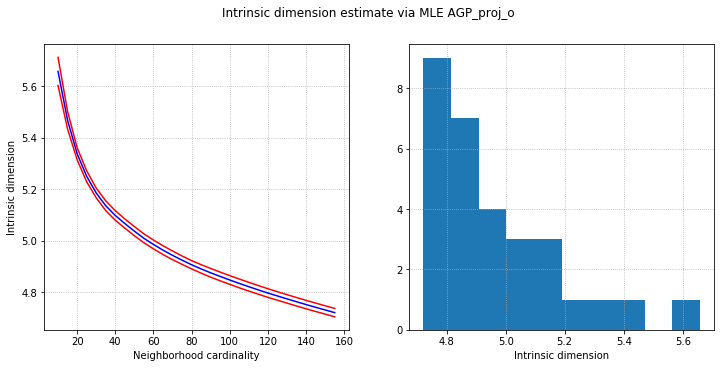

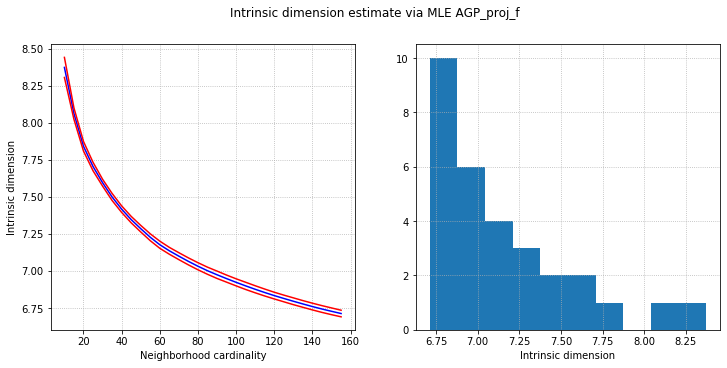

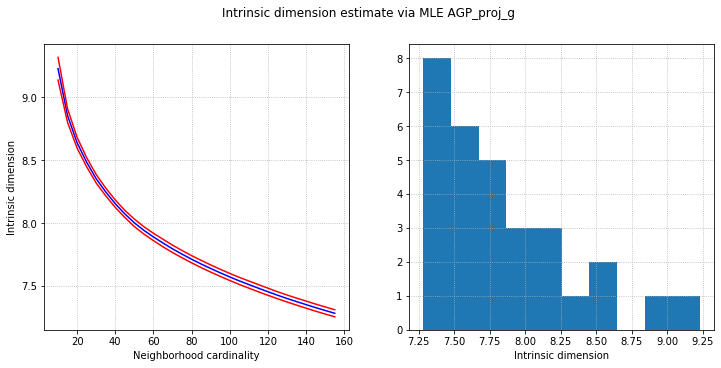

In [44]:
dims = {}
# plotting the result
for k in indims.keys():
    intdim_k_repeated = indims[k]
    neighbors = neigh[k]
    
    fig = plt.figure(figsize=(12,5.25))

    plt.suptitle("Intrinsic dimension estimate via MLE " + k.split("/")[-1].split(".")[0])
    
    floor_n_ceil = np.concatenate((np.floor(np.mean(intdim_k_repeated, axis=0)).astype(int), 
                                    np.ceil(np.mean(intdim_k_repeated, axis=0)).astype(int)))
    
    dims[k] = np.unique(np.round(np.mean(intdim_k_repeated, axis=0))).astype(int)
    plt.subplot(121)
    plt.xlabel("Neighborhood cardinality")
    plt.ylabel("Intrinsic dimension")
    plt.grid(linestyle='dotted')

    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0), 'b')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
    plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0), 'b')
#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
#     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

    plt.subplot(122)
    plt.xlabel("Intrinsic dimension")
    plt.grid(linestyle="dotted")

    plt.hist(intdim_k_repeated.mean(axis=0))
    plt.show()

In [48]:
dims = {'./separate_datasets_proj/AGP_proj_o.csv':[5],
 './separate_datasets_proj/AGP_proj_f.csv': [7],
 './separate_datasets_proj/AGP_proj_g.csv': [8]}

In [50]:
intrinsic_dims_strict = np.load('intrinsic_dims_separate.npy', allow_pickle=True).item()
for k,v in dims.items():
    intrinsic_dims_strict[k] = v

In [53]:
# np.save('intrinsic_dims_' +  ('merged' if 'merged' in root else 'separate') + '_strict', intrinsic_dims_strict)

# Example

In [35]:
# from sklearn.datasets import make_swiss_roll, make_blobs
# from sklearn.preprocessing import PolynomialFeatures

# n = 500

# swiss_roll = make_swiss_roll(n)[0]
# blobs = make_blobs(n)[0]

# # blobs_ext = np.zeros((n, 100))
# # swiss_roll_ext = np.zeros((n, 100))

# blobs_ext = np.zeros((n, 100))
# swiss_roll_ext = np.zeros((n, 100))

# blobs_ext[:,:2] = blobs
# swiss_roll_ext[:,:3] = swiss_roll

In [58]:
# # swiss_roll_tsne = TSNE(n_components=128, n_jobs=-1, method='exact').fit_transform(swiss_roll)
# swiss_roll_mds = MDS(n_components=128, n_jobs=-1).fit_transform(swiss_roll)

In [44]:
# pf = PolynomialFeatures(include_bias=False)
# swiss_roll_pf = pf.fit_transform(swiss_roll)

In [59]:
# intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
#                              swiss_roll_mds, 
#                              mode='bootstrap', 
#                              nb_iter=100, # nb_iter for bootstrapping 
#                              k1=5, 
#                              k2=20)
# intdim_k_repeated = np.array(intdim_k_repeated)

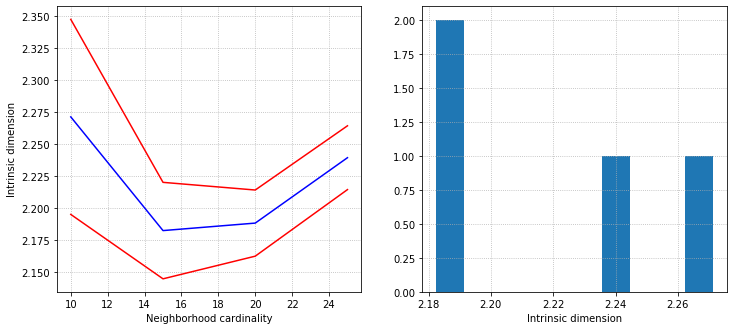

In [60]:
# fig = plt.figure(figsize=(12,5.25))

# floor_n_ceil = np.concatenate((np.floor(np.mean(intdim_k_repeated, axis=0)).astype(int), 
#                                 np.ceil(np.mean(intdim_k_repeated, axis=0)).astype(int)))
# plt.subplot(121)
# plt.xlabel("Neighborhood cardinality")
# plt.ylabel("Intrinsic dimension")
# plt.grid(linestyle='dotted')

# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0), 'b')
# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

# #     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0), 'b')
# #     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
# #     plt.plot(neighbors, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

# plt.subplot(122)
# plt.xlabel("Intrinsic dimension")
# plt.grid(linestyle="dotted")

# plt.hist(intdim_k_repeated.mean(axis=0))
# plt.show()